In [55]:
Base.:(==)(s1::Tuple{Int,Int}, s2::Tuple{Int,Int}) = (s1[1] == s2[1]) && (s1[2] == s2[2])
Base.:+(s1::Tuple{Int,Int}, s2::Tuple{Int,Int}) = (s1[1] + s2[1], s1[2] + s2[2])
Base.:-(s1::Tuple{Int,Int}, s2::Tuple{Int,Int}) = (s1[1] - s2[1], s1[2] - s2[2])
Base.:(==)(s1::Tuple{Tuple{Int,Int},Tuple{Int,Int}}, s2::Tuple{Tuple{Int,Int},Tuple{Int,Int}}) = (s1[1] == s2[1]) && (s1[2] == s2[2])
Base.:(==)(s1::Tuple{Tuple{Int,Int},Tuple{Int,Int},Tuple{Int,Int}}, s2::Tuple{Tuple{Int,Int},Tuple{Int,Int},Tuple{Int,Int}}) = (s1[1] == s2[1]) && (s1[2] == s2[2]) && (s1[3] == s2[3])

function check_key(key::Tuple{Tuple{Int,Int},Tuple{Int,Int},Tuple{Int,Int}}, dic::Dict)
    if key in keys(dic)
        return true
    end
    return false
end
function check_key(key::Tuple{Tuple{Int,Int},Tuple{Int,Int}}, dic::Dict)
    if key in keys(dic)
        return true
    end
    return false
end
function check_key(key::Tuple{Int,Int}, dic::Dict)
    if key in keys(dic)
        return true
    end
    return false
end
#T(s,a,s')
#Tuple{Tuple{Int,Int},Tuple{Int,Int},Tuple{Int,Int}} -> Float64
dict_T = Dict()

#R(s,a)
#Tuple{Tuple{Int,Int},Tuple{Int,Int}} -> Float64
dict_R = Dict()

r_bump_border = -1
discountFactor = 0.85
p_intended = 0.7
special_hex_rewards = Dict{Tuple{Int,Int}, Float64}(
    (0,1)=>  5.0, # left side reward
    (2,0)=>-10.0, # left side hazard
    (9,0)=> 10.0, # right side reward
)
function hex_neighbors(hex::Tuple{Int,Int})
    i,j = hex
    [(i+1,j),(i,j+1),(i-1,j+1),(i-1,j),(i,j-1),(i+1,j-1)]
end
function check_left_index(s::Tuple{Int,Int},a::Tuple{Int,Int})
    val = findfirst(u -> u == a,hex_neighbors(s))
    return mod1(val+1, 6)
end
function check_right_index(s::Tuple{Int,Int},a::Tuple{Int,Int})
    val = findfirst(u -> u == a,hex_neighbors(s))
    return mod1(val-1, 6)
end
state =  [(0,0),(1,0),(2,0),(3,0),(0,1),(1,1),(2,1),(-1,2),
(0,2),(1,2),(2,2),(3,2),(4,2),(5,2),(6,2),(7,2),
(8,2),(4,1),(5,0),(6,0),(7,0),(7,1),(8,1),(9,0),(-100,-100)]
function T(s,a,s′)
    if !check_key((s,a,s′), dict_T)
        return 0
    end
    return dict_T[(s,a,s′)]
end
function R(s,a=missing)
    if !check_key(s, dict_R)
        return 0
    end
    return dict_R[s]
end


function calcTransitionAndReward(hexes::Vector{Tuple{Int,Int}})
    null_state = (-100,-100)
    p_veer = 0.15
    for s in hexes
        if s == null_state
            continue
        end
        if !haskey(special_hex_rewards,s)
            neighbors = hex_neighbors(s)
            for a in neighbors
                s′ = a
                if !(a in hexes)
                    if check_key(s,dict_R)
                        dict_R[s] += r_bump_border*p_intended
                    else
                        s′ = s
                        dict_R[s] = r_bump_border*p_intended
                    end
                end
                if check_key((s,a-s,s′),dict_T)
                    dict_T[(s,a-s,s′)] += p_intended
                else
                    dict_T[(s,a-s,s′)] = p_intended
                end

                #Go left
                a_left = check_left_index(s,a)
                neigh_left = neighbors[a_left]
                s′ = neigh_left
                if !(s′ in hexes)
                    if check_key(s,dict_R)
                        dict_R[s] += r_bump_border*p_veer
                    else
                        s′ = s
                        dict_R[s] = r_bump_border*p_veer
                    end
                end
                if check_key((s,a-s,s′),dict_T)
                    dict_T[(s,a-s,s′)] += p_veer
                else
                    dict_T[(s,a-s,s′)] = p_veer
                end
                
                #Go right
                a_right = check_right_index(s,a)
                neigh_right = neighbors[a_right]
                s′ = neigh_right
                if !(s′ in hexes)
                    if check_key(s,dict_R)
                        dict_R[s] += r_bump_border*p_veer
                    else
                        s′ = s
                        dict_R[s] = r_bump_border*p_veer
                    end
                end
                if check_key((s,a-s,s′),dict_T)
                    dict_T[(s,a-s,s′)] += p_veer
                else
                    dict_T[(s,a-s,s′)] = p_veer
                end
            end
        else
            action = hex_neighbors(s)
            for a in action
                dict_T[(s,a-s,null_state)] = 1.0
                if check_key(s,dict_R)
                    dict_R[s] += special_hex_rewards[s]
                else
                    dict_R[s] = special_hex_rewards[s]
                end
            end
        end
    end
    action = hex_neighbors((0,0))
    for a in action
        dict_T[(null_state,a,null_state)] = 0.0
    end
end

struct MDP
    γ # discount factor
    𝒮 # state space
    𝒜 # action space
    T # transition function
    R # reward function
    TR # sample transition and reward
end
MDP(γ, 𝒮, 𝒜, T, R) = MDP(γ, 𝒮, 𝒜, T, R, nothing)

function lookahead(𝒫::MDP, U, s, a)
    𝒮, T, R, γ = 𝒫.𝒮, 𝒫.T, 𝒫.R, 𝒫.γ
    return R(s,a) + γ*sum(T(s,a,s′)*U(s′) for s′ in 𝒮)
end

function lookahead(𝒫::MDP, U::Vector, s, a)
    𝒮, T, R, γ = 𝒫.𝒮, 𝒫.T, 𝒫.R, 𝒫.γ
    return R(s,a) + γ*sum(T(s,a,s′)*U[i] for (i,s′) in enumerate(𝒮))
end

struct ValueFunctionPolicy
    𝒫 # problem
    U # utility function
end

function greedy(𝒫::MDP, U, s)
    u, a = _findmax(a->lookahead(𝒫, U, s, a), 𝒫.𝒜)
    return (a=a, u=u)
end

function (π::ValueFunctionPolicy)(s)
    return greedy(π.𝒫, π.U, s).a
end

function backup(𝒫::MDP, U, s)
    return maximum(lookahead(𝒫, U, s, a) for a in 𝒫.𝒜)
end
struct ValueIteration
    k_max # maximum number of iterations
end


function solve(M::ValueIteration, 𝒫::MDP)
    U = [0.0 for s in 𝒫.𝒮]
    for k = 1:M.k_max
        U = [backup(𝒫, U, s) for s in 𝒫.𝒮]
    end
    return ValueFunctionPolicy(𝒫, U)
end

action =[(1,0),(0,1),(-1,1),(-1,0),(0,-1),(1,-1)]
calcTransitionAndReward(state)
M = ValueIteration(10)
MD = MDP(discountFactor,state,action,T,R)
value = solve(M,MD).U


25-element Vector{Float64}:
  15.908297594491398
  20.110259619452833
 -60.85
  -2.5415242866010708
  29.15
  21.4723451889828
  11.460773454919778
  15.908297594491398
  20.110259619452833
  14.798499207299152
   ⋮
  18.703469958875075
  -2.1598335944155522
  -3.022112973006392
   2.3125844844015195
  10.118179272902694
  23.72879408878279
  33.19425
  59.15
  -1.0

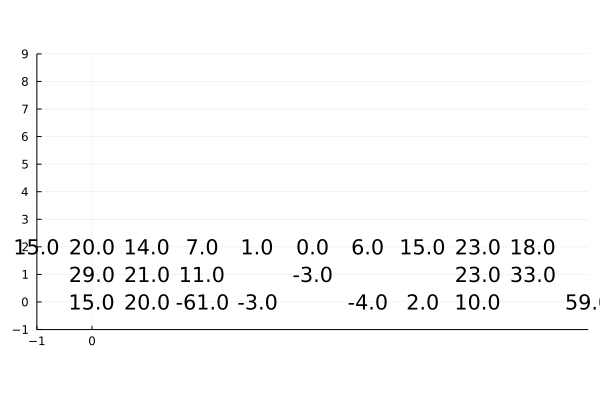

In [56]:
using Plots
gr()
plot(xticks = -1:0, yticks = -1:9, xlim = (-1, 9), ylim = (-1,9), aspect_ratio = 0.5)
annotate!(map(x -> x[1],state),map(x -> x[2],state),map(x -> floor(x),value))
